# Introduction

In this notebook, we validate the refitted MatGL implementation of the M3GNet universal potential against the original TF version using cubic crystals. This is purely for convenience and demonstration purposes. The test can be carried out on any crystal. If you are running this in Google Colab, please uncomment the following lines.


In [ ]:
# !pip install m3gnet
# !pip install matgl
# !pip install pymatgen
# !pip install --upgrade mp-api

In [ ]:
from __future__ import annotations

import os
import warnings

import pandas as pd
from m3gnet.models import M3GNet as M3GNet_tf
from m3gnet.models import M3GNetCalculator as M3GNetCalculator_tf
from m3gnet.models import Potential as Potential_tf
from pymatgen.core import Composition, Lattice, Structure
from pymatgen.ext.matproj import MPRester
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

import matgl
from matgl.ext.ase import M3GNetCalculator as M3GNetCalculator_matgl

warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_html("http://en.wikipedia.org/wiki/Lattice_constant")[0]
struct_types = [
    "Hexagonal",
    "Wurtzite",
    "Wurtzite (HCP)",
    "Orthorhombic",
    "Tetragonal perovskite",
    "Orthorhombic perovskite",
]
data = data[~data["Crystal structure"].isin(struct_types)]
data = data.rename(columns={"Lattice constant (Å)": "a (Å)"})
data = data.drop(columns=["Ref."])
data["a (Å)"] = data["a (Å)"].map(float)
data = data[["Material", "Crystal structure", "a (Å)"]]


additional_fcc = """10 Ne 4.43 54 Xe 6.20
13 Al 4.05 58 Ce 5.16
18 Ar 5.26 70 Yb 5.49
20 Ca 5.58 77 Ir 3.84
28 Ni 3.52 78 Pt 3.92
29 Cu 3.61 79 Au 4.08
36 Kr 5.72 82 Pb 4.95
38 Sr 6.08 47 Ag 4.09
45 Rh 3.80 89 Ac 5.31
46 Pd 3.89 90 Th 5.08"""

additional_bcc = """3 Li 3.49 42 Mo 3.15
11 Na 4.23 55 Cs 6.05
19 K 5.23 56 Ba 5.02
23 V 3.02 63 Eu 4.61
24 Cr 2.88 73 Ta 3.31
26 Fe 2.87 74 W 3.16
37 Rb 5.59 41 Nb 3.30"""


def add_new(str_, structure_type, df):
    tokens = str_.split()
    new_crystals = []
    for i in range(int(len(tokens) / 3)):
        el = tokens[3 * i + 1].strip()
        if el not in df["Material"].to_numpy():
            new_crystals.append([tokens[3 * i + 1], structure_type, float(tokens[3 * i + 2])])
    df2 = pd.DataFrame(new_crystals, columns=data.columns)
    return pd.concat([df, df2])


data = add_new(additional_fcc, "FCC", data)
data = add_new(additional_bcc, "BCC", data)
data = data[data["Material"] != "NC0.99"]
data = data[data["Material"] != "Xe"]
data = data[data["Material"] != "Kr"]
data = data[data["Material"] != "Rb"]
data = data.set_index("Material")
print(data)

             Crystal structure     a (Å)
Material                                
C (diamond)      Diamond (FCC)  3.567000
Si               Diamond (FCC)  5.431021
Ge               Diamond (FCC)  5.658000
AlAs         Zinc blende (FCC)  5.660500
AlP          Zinc blende (FCC)  5.451000
...                        ...       ...
Cs                         BCC  6.050000
K                          BCC  5.230000
Ba                         BCC  5.020000
Eu                         BCC  4.610000
Cr                         BCC  2.880000

[89 rows x 2 columns]


Let's load the old and new M3GNet models.


In [ ]:
# MatGL M3Gnet
potential_matgl = matgl.load_model("M3GNet-MP-2021.2.8-PES")
calc_matgl = M3GNetCalculator_matgl(potential_matgl)

# TF M3Gnet
model_tf = M3GNet_tf.load("MP-2021.2.8-EFS")
potential_tf = Potential_tf(model_tf)
calc_tf = M3GNetCalculator_tf(potential_tf)

adapter = AseAtomsAdaptor()

In [ ]:
os.environ["MPRESTER_MUTE_PROGRESS_BARS"] = "true"  # Mute progress bars for cleaner output.
mpr = MPRester()

structures = {}
results = []

for formula, v in data.iterrows():
    formula = formula.split()[0]
    c = Composition(formula)
    els = sorted(c.elements)
    cs = v["Crystal structure"]

    # We initialize all the crystals with an arbitrary lattice constant of 5 angstroms.
    if "Zinc blende" in cs:
        s = Structure.from_spacegroup("F-43m", Lattice.cubic(5), [els[0], els[1]], [[0, 0, 0], [0.25, 0.25, 0.75]])
    elif "Halite" in cs:
        s = Structure.from_spacegroup("Fm-3m", Lattice.cubic(5), [els[0], els[1]], [[0, 0, 0], [0.5, 0, 0]])
    elif "Caesium chloride" in cs:
        s = Structure.from_spacegroup("Pm-3m", Lattice.cubic(5), [els[0], els[1]], [[0, 0, 0], [0.5, 0.5, 0.5]])
    elif "Cubic perovskite" in cs:
        s = Structure(
            Lattice.cubic(5),
            [els[0], els[1], els[2], els[2], els[2]],
            [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, 0], [0.0, 0.5, 0.5], [0.5, 0, 0.5]],
        )
    elif "Diamond" in cs:
        s = Structure.from_spacegroup("Fd-3m", Lattice.cubic(5), [els[0]], [[0.25, 0.75, 0.25]])
    elif "BCC" in cs:
        s = Structure(Lattice.cubic(5), [els[0]] * 2, [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]])
    elif "FCC" in cs:
        s = Structure(Lattice.cubic(5), [els[0]] * 4, [[0.0, 0.0, 0.0], [0.5, 0.5, 0], [0.0, 0.5, 0.5], [0.5, 0, 0.5]])
    else:
        continue
    try:
        mids = mpr.get_material_ids(s.composition.reduced_formula)
        for i in mids:
            try:
                structure = mpr.get_structure_by_material_id(i)
                sga = SpacegroupAnalyzer(structure)
                sga2 = SpacegroupAnalyzer(s)
                if sga.get_space_group_number() == sga2.get_space_group_number():
                    conv = sga.get_conventional_standard_structure()
                    structures[s.composition.reduced_formula] = conv
                    atoms_tf = adapter.get_atoms(conv)
                    atoms_matgl = adapter.get_atoms(conv)
                    atoms_tf.calc = calc_tf
                    atoms_matgl.calc = calc_matgl
                    results.append(
                        [
                            s.composition.reduced_formula,
                            atoms_tf.get_potential_energy() / len(s),
                            float(atoms_matgl.get_potential_energy() / len(s)),
                        ]
                    )
                    break
            except Exception:
                pass
    except Exception:
        pass

2023-06-16 05:52:27.360487: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
Isolated atoms found in the structure


In [ ]:
df = pd.DataFrame(results, columns=["Formula", "MatGL Energy per Atom", "TF Energy per Atom"])
df["Difference"] = df["MatGL Energy per Atom"] - df["TF Energy per Atom"]
df = df.set_index("Formula")
df.sort_index().style.background_gradient()

,MatGL Energy per Atom,TF Energy per Atom,Difference
Formula,,,
Ac,-4.099037,-4.098995,-0.000042
Ag,-2.811852,-2.798091,-0.013762
Al,-3.742051,-3.759993,0.017942
AlAs,-4.643467,-4.708796,0.065328
AlP,-5.181847,-5.210092,0.028244
AlSb,-4.093573,-4.078317,-0.015256
Ar,-0.054958,-0.060761,0.005803
Au,-3.264417,-3.265215,0.000799
BN,-8.705638,-8.660206,-0.045432


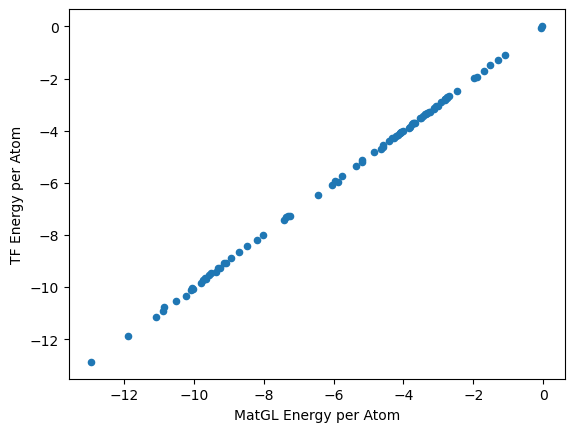

In [ ]:
_ = df.plot(x="MatGL Energy per Atom", y="TF Energy per Atom", kind="scatter")

In [ ]:
mae = df["Difference"].abs().mean()
print(f"The mean absolute difference between the MatGL and TF energy per atom is {mae:.5f} eV/atom.")

The mean absolute difference between the MatGL and TF energy per atom is 0.02466 eV/atom.
